In [1]:
import pickle
from matplotlib import pyplot 

In [2]:
hist = pickle.load(open( 'history.pkl' , "rb" ))

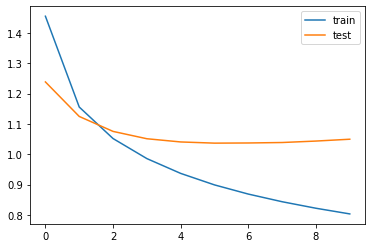

In [3]:

pyplot.plot(hist['loss'], label='train') 
pyplot.plot(hist['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [4]:
import numpy as np
import pandas as pd 
import pickle
from time import time
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
#cleanfilename = 'cleandatamini.pkl'
cleanfilename = 'cleandata.pkl'
modelfilename = 'model.json'
weightsfilename = 'model.h5'
historyfilename = 'history.pkl'


# In[2]:


print('Loading training data.')


# In[3]:


clean_data = pickle.load( open( cleanfilename , "rb" ) )


# In[4]:


print('Training data loaded. Shape is', clean_data.shape)


# In[27]:


print('Starting to build the embedding index.')


# In[28]:


embeddings_index = {}
f = open('data/glove/glove.6B/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


# In[29]:


print('Built embeddings index. Found %s word vectors.' % len(embeddings_index))


# In[30]:


def doc2seq(texts, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM):
    tokenizer = Tokenizer(filters='"#$%&()*+-/<=>@[\\]^_`{|}~\t\n')
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    word_index = tokenizer.word_index
    index_word = tokenizer.index_word
    print('Found %s unique tokens.' % len(word_index))

    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding = 'post')
    
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return data, embedding_matrix, word_index, index_word


# In[31]:


print('Building text')


# In[32]:


MAX_TEXT_LENGTH = 100
EMBEDDING_DIM = 300
data = clean_data.text

x_data, encoder_emb, x_word_index, x_index_word = doc2seq(data, MAX_TEXT_LENGTH, EMBEDDING_DIM)


# In[33]:


print('Text built. Lengths of x_data, encoder_emb, x_word_index, x_index_word are', 
      list(map(lambda a:len(a), [x_data, encoder_emb, x_word_index, x_index_word ])))


# In[34]:


print('Building headlines ')


# In[35]:


MAX_HEADLINE_LENGTH = 30
EMBEDDING_DIM = 300
data = clean_data.headline

y_data, decoder_emb, y_word_index, y_index_word = doc2seq(data, MAX_HEADLINE_LENGTH, EMBEDDING_DIM)


# In[36]:


print('Headlines built. Lengths of y_data, decoder_emb, y_word_index, y_index_word are', 
      list(map(lambda a:len(a), [y_data, decoder_emb, y_word_index, y_index_word])))


# In[37]:


x_train, x_test_temp, y_train, y_test_temp = train_test_split(x_data, y_data, 
                                                            test_size=0.3, random_state=0) 


# In[38]:


x_dev, x_test, y_dev, y_test = train_test_split(x_test_temp, y_test_temp, 
                                                            test_size=0.33, random_state=0) 


# In[39]:


print('Test Train Dev split done. Length of x_train, y_train,x_dev, y_dev, x_test, y_test are', 
     list(map(len, [x_train, y_train,x_dev, y_dev, x_test, y_test])))


Loading training data.
Training data loaded. Shape is (1387290, 2)
Starting to build the embedding index.
Built embeddings index. Found 400000 word vectors.
Building text
Found 212813 unique tokens.
Text built. Lengths of x_data, encoder_emb, x_word_index, x_index_word are [1387290, 212814, 212813, 212813]
Building headlines 
Found 78682 unique tokens.
Headlines built. Lengths of y_data, decoder_emb, y_word_index, y_index_word are [1387290, 78683, 78682, 78682]
Test Train Dev split done. Length of x_train, y_train,x_dev, y_dev, x_test, y_test are [971103, 971103, 278845, 278845, 137342, 137342]


In [5]:
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, TimeDistributed, Embedding
from tensorflow.keras.models import Model
from attention_keras.layers.attention import AttentionLayer

In [20]:
MAX_TEXT_LENGTH = 100
MAX_HEADLINE_LENGTH = 30
EMBEDDING_DIM = 300
hidden_units = 400

In [21]:
def create_model():
    enc_embedding_layer = Embedding(len(x_word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[encoder_emb],
                                input_length=MAX_TEXT_LENGTH,
                                trainable=False,
                                name='EncoderEmbeddingLayer')


    dec_embedding_layer = Embedding(len(y_word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[decoder_emb],
                                input_length=MAX_HEADLINE_LENGTH,
                                trainable=False,
                                name='DecoderEmbeddingLayer')


    # Encoder 

    # Encoder input 
    # 2D (sequence_length, None), where sequence length is the MAX_LEN unified by padding in preprocessing
    encoder_inputs = Input(shape=(MAX_TEXT_LENGTH,), name="EncoderInput") 
    enc_emb = enc_embedding_layer(encoder_inputs) 


    #LSTM 1 
    encoder_lstm1 = LSTM(hidden_units,return_sequences=True,return_state=True, name='EncLSTM1') 
    encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

    #LSTM 2 
    encoder_lstm2 = LSTM(hidden_units,return_sequences=True,return_state=True, name='EncLSTM2') 
    encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

    #LSTM 3 
    encoder_lstm3=LSTM(hidden_units, return_state=True, return_sequences=True, name='EncLSTM3') 
    encoder_output3, state_h3, state_c3= encoder_lstm3(encoder_output2) 

    #LSTM 4 
    encoder_lstm4=LSTM(hidden_units, return_state=True, return_sequences=True, name='EncLSTM4') 
    encoder_outputs, state_h, state_c= encoder_lstm4(encoder_output3) 

    # Decoder 

    decoder_inputs = Input(shape=(None,), name = 'DecoderInput') 
    #dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
    dec_emb = dec_embedding_layer(decoder_inputs) 

    #LSTM using encoder_states as initial state
    decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True, name='DecLSTM1') 
    decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

    #Attention Layer
    attn_layer = AttentionLayer(name='attention_layer') 
    attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

    # Concat attention output and decoder LSTM output 
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

    #Dense layer
    decoder_dense = TimeDistributed(Dense(len(y_word_index)+1, activation='softmax')) 
    decoder_outputs = decoder_dense(decoder_concat_input) 

    return Model([encoder_inputs, decoder_inputs], decoder_outputs)




In [22]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    parallel_model = create_model() 
    parallel_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

parallel_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
EncoderEmbeddingLayer (Embeddin (None, 100, 300)     63844200    EncoderInput[0][0]               
__________________________________________________________________________________________________
EncLSTM1 (LSTM)                 [(None, 100, 400), ( 1121600     EncoderEmbeddingLayer[0][0]      
__________________________________________________________________________________________________
EncLSTM2 (LSTM)                 [(None, 100, 400), ( 1281600     EncLSTM1[0][0]                   
____________________________________________________________________________________________

In [23]:
parallel_model.load_weights("model_fd_111519_300units_punct.h5")
print("Loaded model from disk")

Loaded model from disk


In [24]:
encoder_inputs = parallel_model.input[0]
encoder_model = Model(inputs = encoder_inputs, outputs = parallel_model.get_layer('EncLSTM4').output)

decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_hidden_state_input = Input(shape=(MAX_TEXT_LENGTH,hidden_units))

# Get the embeddings of the decoder sequence
dec_emb2= parallel_model.get_layer('DecoderEmbeddingLayer')(parallel_model.input[1])

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = parallel_model.get_layer('DecLSTM1')(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = parallel_model.get_layer('attention_layer')([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = parallel_model.layers[-1](decoder_inf_concat) #This is the time distributed layer

# Final decoder model
decoder_model = Model(
[parallel_model.input[1]] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [25]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0 ):
            newString=newString+y_index_word[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+x_index_word[i]+' '
    return newString

In [26]:
def get_top_beam_search_sentences(input_seq, beam=3):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    top_sentences = {}
    
    def top_tokens(last_token, out, h, c):
        output_tokens, h_new, c_new = decoder_model.predict([[last_token]] + [out, h, c])
        top_token_indexes = np.argsort(output_tokens[0, -1, :])[-beam:]
        top_probabilities = output_tokens[0,-1, top_token_indexes]
        return top_token_indexes, top_probabilities, h_new, c_new
        
    #first set of tokens when feeding encoder states and 0 as the first token to the decoder.
    first_tokens, first_probabilities, h, c = top_tokens(0, e_out, e_h, e_c)
    for first_token, first_probability in zip(first_tokens, first_probabilities):
        #initialize top sentences, their corresponding probabilities and states
        top_sentences[y_index_word.get(first_token, '')] = (first_probability, h, c)
    
    
    #loop to iterate over next tokens
    len = 1
    while len < MAX_HEADLINE_LENGTH:
        candidate_sentences = {}
        for sentence, (probability, h, c) in top_sentences.items():
            last_word = sentence.split()[-1] #pick the last word in the sentence as next word
            if(last_word != '.'):
                token = y_word_index.get(last_word, 0) 
                next_tokens, next_probabilities, h_next, c_next = top_tokens(token, e_out, h, c)
                for next_token, next_probability in zip(next_tokens, next_probabilities):
                    new_sentence = sentence.strip() + ' ' + y_index_word.get(next_token, '')
                    candidate_sentences[new_sentence.strip()] = (probability * next_probability, h_next, c_next)
            else:
                candidate_sentences[sentence] = (probability, h, c)

        #print('Candidate sentences')
        #print(candidate_sentences.keys())
        
        #remove low probability candidates
        low_probability_candidates = sorted(candidate_sentences, key=lambda k: candidate_sentences.get(k)[0])[:-beam]
        for low_probability_candidate in low_probability_candidates:
            candidate_sentences.pop(low_probability_candidate)
        
        #Now all candidates left have highest probabilities.
        top_sentences = candidate_sentences
        len = len + 1
        #print('Sentences at the bottom of the loop')
        #print(top_sentences.keys())
        

    return top_sentences

def decode_sequence(input_seq, beam=3):
    top_sentences_obj = get_top_beam_search_sentences(input_seq.reshape(1,-1), beam)
    l = [(sen, prob) for sen, (prob, _, _) in top_sentences_obj.items()]
    return sorted(l, key = lambda x:-x[1])[0][0]

In [27]:
from metrics import rouge_n_sentence_level

In [34]:
def return_decode(x): 
    gen_output = decode_sequence(x.reshape(1,-1)).split()
    candidate = [item for item in gen_output if (item!="." and item!="")] 
    return(candidate)

def return_summary(x): 
    gen_summary = seq2summary(x).split()
    reference =  [item for item in gen_summary if (item!="." and item!="")] 
    return(reference)

# Other useful links to keep in mind: 
# https://stackoverflow.com/questions/38045290/text-summarization-evaluation-bleu-vs-rouge

def calc_indiv_rouge(id_text, text_df, headline_df, rouge_n): 
    # This function will take the following as inputs: 
    # id_text: the index you are interested in 
    # gen_text_df: the sequences that hold the full text 
    # headline_df: the sequences that hold the headline text 
    
    # -- Step 1: generate the decoded sequence from a given sample of text
    gen_output = decode_sequence(text_df[id_text].reshape(1,-1))
    split_output = gen_output.split(" ")
    candidate = [item for item in split_output if (item!="." and item!="")] #get rid of empty spaces and periods 
    # -- Step 2: generate the true headline summary from our labelled headline text
    gen_ref = seq2summary(headline_df[id_text])
    split_ref = gen_ref.split(" ")
    #get rid of empty spaces and periods (there shouldn't be any as we already cleaned the headline, but just in case)
    reference = [item for item in split_ref if (item!="." and item!="")] 
    # -- Step 3: calculate rouge
    recall, precision, rouge = rouge_n_sentence_level(candidate, reference, rouge_n)
    # rouge is actually an f-score of the recall and precision 
    return(recall, precision, rouge)

In [29]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [35]:
chunkholder = list(chunks(range(0, 10000), 100))

result = []
cumulative_list=list(range(100,10100,100))
cumulative_avg = []
for chunk in chunkholder: 
#    -- change the function return_decode to whatever function you need (i.e. beam search)
   decode_machine_summary = [return_decode(item) for item in x_test[chunk]]
#    -- for beamsearch, I used: decode_machine_summary = [beam_decode_sequence(item).split(' ') for item in x_test[chunk]]
   decode_ref_summary = [return_summary(item) for item in y_test[chunk]]
   testset = pd.concat([pd.Series(decode_machine_summary), pd.Series(decode_ref_summary)], axis=1)
   testset.columns = ['gen_summary','ref_summary']
   testset['rouge_cols']=testset.apply(lambda x: rouge_n_sentence_level(x['gen_summary'], x['ref_summary'], 1), axis=1)
   allrouge = testset['rouge_cols'].apply(pd.Series)
   allrouge.columns = ['recall','precision','f1score']
   final = pd.concat([testset,allrouge],axis=1) 
   result.append(final)
   print('*', end = '')


result_df = pd.concat(result).reset_index(drop=True) #this holds the decoded sequences up to 10,000



for i in cumulative_list: 
#   -- calculate the average from every 100 chunk (i.e. 0 to 100, 0 to 200, 0 to 300, etc)
   temp = result_df.loc[0:i,'recall':'f1score'].apply(lambda x: np.nanmean(x), axis=0)
   cumulative_avg.append({'recall': temp['recall'],'precision': temp['precision'],'f1score': temp['f1score']})

cumulative_avg_df = pd.DataFrame(cumulative_avg) # This holds the cumulative sample averages up to 10,000


****************************************************************************************************

In [31]:
#greedy
cumulative_avg_df

,recall,precision,f1score
0,0.208132,0.259218,0.213810
1,0.203636,0.263188,0.211918
2,0.189033,0.248933,0.197744
3,0.192547,0.252777,0.201850
4,0.193522,0.246659,0.201689
...,...,...,...
95,0.187269,0.252648,0.198163
96,0.187499,0.253086,0.198510
97,0.187768,0.253570,0.198776
98,0.187919,0.253856,0.198936


In [36]:
#beam
cumulative_avg_df

,recall,precision,f1score
0,0.166538,0.266007,0.186382
1,0.177433,0.283665,0.198705
2,0.174399,0.279130,0.196851
3,0.181962,0.282020,0.202711
4,0.184925,0.280657,0.205810
...,...,...,...
95,0.172760,0.272836,0.196485
96,0.172981,0.273225,0.196789
97,0.173111,0.273417,0.196891
98,0.173048,0.273487,0.196820


In [37]:
for i in range (4000, 4050):
    print('------------Beam Search--------------------------', i)
    print(decode_sequence(x_test[i].reshape(1,-1), 3))
    print('------------Greedy Search------------------------')
    print(decode_sequence(x_test[i].reshape(1,-1), 1))
    print('------------Ground Truth-------------------------')
    print(seq2summary(y_test[i]))
    print('------------Document-----------------------------')    
    print(seq2text(x_test[i]))
    print('=================================================')


------------Beam Search-------------------------- 4000
put your horse in the saddle .
------------Greedy Search------------------------
keep your horse in the saddle .
------------Ground Truth-------------------------
keep your legs handing close to your horse s side , without gripping at the knee . 
------------Document-----------------------------
your legs will hold you in the saddle , and give your horse cues . 
------------Beam Search-------------------------- 4001
use a utility knife to cut the thinset into a circular saw .
------------Greedy Search------------------------
cut the blade into the jamb .
------------Ground Truth-------------------------
turn on the saw and let the blade do the work cutting the tile . 
------------Document-----------------------------
the cut will be cleaner if you do not force the tile into the blade . 
------------Beam Search-------------------------- 4002
wrap the ends of the string around the headband .
------------Greedy Search-----------------

cut the cutter into the cutter .
------------Ground Truth-------------------------
locate the leading cutter as your starting point . 
------------Document-----------------------------
shortest cutter on the chain . if all of the cutters seem to be the same length , you may start anywhere . the main concern is that you file each cutter so that the flat edge on top of each cutter is very nearly the same length . that way each will slice away the same amount of wood as they pass through the kerf of your cut . it also may help to mark the first tooth you file with a dab of paint or a permanent marker so you will be sure of where you started . 
------------Beam Search-------------------------- 4013
get a pillow .
------------Greedy Search------------------------
consider the benefits of a pillow .
------------Ground Truth-------------------------
understand the pillow is not for everyone . 
------------Document-----------------------------
fussy or difficult to nurse when using the pillow 

play the game .
------------Greedy Search------------------------
continue adding cards .
------------Ground Truth-------------------------
set aside pairs . 
------------Document-----------------------------
when you have found two cards that are a match , set that pair aside so that your game board becomes smaller . continue playing until every card has been turned over and you have created matches for each game piece . when you are finished playing , you can simply shuffle your cards and redistribute them to create your game board and play again . 
------------Beam Search-------------------------- 4025
cook the pancakes .
------------Greedy Search------------------------
cook the pancakes .
------------Ground Truth-------------------------
cook the pancakes . 
------------Document-----------------------------
on a hot griddle , cook the pancakes of your desired size until golden brown on each side . lay each pancake on a plate . 
------------Beam Search-------------------------- 402

check if you can pay taxes .
------------Greedy Search------------------------
check if you can pay taxes .
------------Ground Truth-------------------------
take care of payroll . 
------------Document-----------------------------
payroll system that accounts for employee hours and pay rates . you must withhold the proper amounts for federal , state and local taxes , and deposit those as required with the taxing authorities . establish a consistent system for payment , whether weekly or bi weekly . for help with federal tax requirements , the irs has put out two publications , the employer’s tax guide , publication , and the employer’s supplemental tax guide , publication a . you can find both publications at the irs publications page , at www . irs . gov forms pubs . 
------------Beam Search-------------------------- 4036
go to route .
------------Greedy Search------------------------
find a cave .
------------Ground Truth-------------------------
go to the southern part of the route

buy your child s clothing .
------------Ground Truth-------------------------
consider stimming opportunities . 
------------Document-----------------------------
both opportunities built into the clothes , and big pockets where they can put stim toys and comfort objects . here are some ways autistic kids like to stim with clothes long skirts are fun for spinning . strings and zippers present fun fidgeting opportunities . fur is good for petting . chunky bracelets or bracelets with big beads can be twirled and spun in the hands . if your child is putting their clothes in their mouth , get them some chewy necklaces or bracelets from a special needs store . these can be found online as well . 
------------Beam Search-------------------------- 4049
prune the roots .
------------Greedy Search------------------------
prune the roots .
------------Ground Truth-------------------------
let the cutting dry out in a lightly shaded location . 
------------Document-----------------------------
di